
--- 'Max Calmar Ratio' 모델 시뮬레이션 시작 ---
Total rebalances: 5
  - 최종 가치: $251,600,223.72, CAGR: 20.29%, MDD: -18.14%, Sharpe: 1.53, Calmar: 1.12

--- 'Max Sharpe Ratio' 모델 시뮬레이션 시작 ---
Total rebalances: 5
  - 최종 가치: $251,600,223.72, CAGR: 20.29%, MDD: -18.14%, Sharpe: 1.53, Calmar: 1.12

--- 'Risk Parity' 모델 시뮬레이션 시작 ---
Total rebalances: 2
  - 최종 가치: $152,807,453.48, CAGR: 8.86%, MDD: -18.16%, Sharpe: 1.10, Calmar: 0.49

--- 'Minimum Variance' 모델 시뮬레이션 시작 ---
Total rebalances: 3
  - 최종 가치: $141,973,405.57, CAGR: 7.27%, MDD: -14.89%, Sharpe: 0.99, Calmar: 0.49

--- 'Target Return (return%)' 모델 시뮬레이션 시작 ---
Total rebalances: 4
  - 최종 가치: $231,528,031.42, CAGR: 18.31%, MDD: -18.03%, Sharpe: 1.44, Calmar: 1.02

--- 'Benchmark (Spy)' 모델 시뮬레이션 시작 ---
  - 최종 가치: $212,728,339.29, CAGR: 16.03%, MDD: -24.50%, Sharpe: 0.94, Calmar: 0.65

--- 'Benchmark (Btc-Usd)' 모델 시뮬레이션 시작 ---
  - 최종 가치: $1,271,331,634.03, CAGR: 66.44%, MDD: -76.63%, Sharpe: 1.15, Calmar: 0.87

상세 성과 보고서가 저장되었습니다: /Users/012oov/

,CAGR,Annualized Volatility,MDD,Sharpe Ratio,Calmar Ratio,Final Value
Model,,,,,,
Max Calmar Ratio,20.29%,12.62%,-18.14%,1.53,1.12,"$251,600,223.72"
Max Sharpe Ratio,20.29%,12.62%,-18.14%,1.53,1.12,"$251,600,223.72"
Risk Parity,8.86%,8.04%,-18.16%,1.10,0.49,"$152,807,453.48"
Minimum Variance,7.27%,7.35%,-14.89%,0.99,0.49,"$141,973,405.57"
Target Return (return%),18.31%,12.21%,-18.03%,1.44,1.02,"$231,528,031.42"
Benchmark (Spy),16.03%,17.53%,-24.50%,0.94,0.65,"$212,728,339.29"
Benchmark (Btc-Usd),66.44%,60.66%,-76.63%,1.15,0.87,"$1,271,331,634.03"


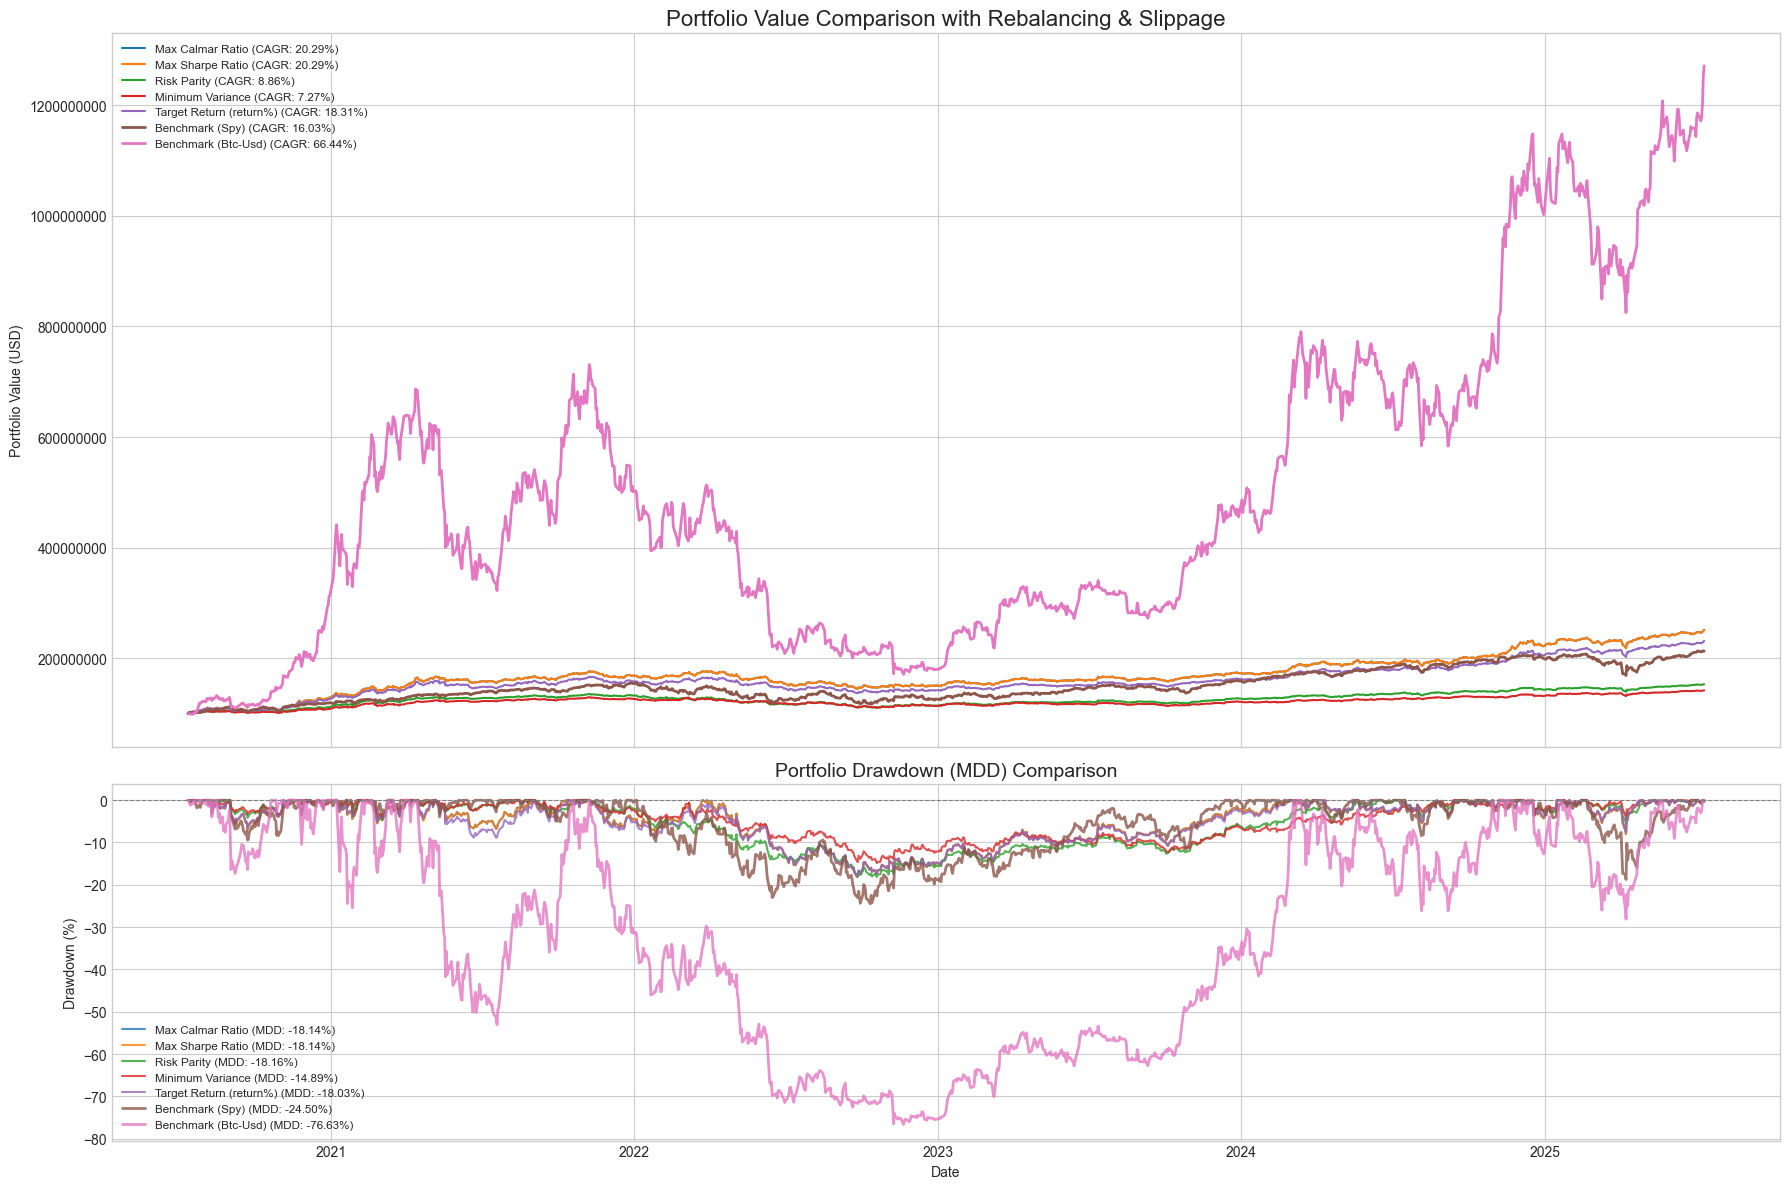

In [3]:
# 7. 실행 파일 2 (각 최적화 비중으로 포트폴리오 구성 시 결과물)

import pandas as pd
import config
from backtester import Backtester
from visualizer import Visualizer
from utils import format_model_name

# 1. 데이터 로드
try:
    price_data = pd.read_csv(config.RAW_DATA_PATH, index_col=0, parse_dates=True)
    all_weights_dict = pd.read_excel(config.OPTIMAL_WEIGHTS_SAVE_PATH, sheet_name=None)
except FileNotFoundError as e:
    print(f"오류: 필수 파일 로드 실패 - {e}\n'1_run_optimization.ipynb'을 먼저 실행하세요.")
    exit()

# 2. 성과 분석 실행
portfolio_results = {}
models_to_run = {**all_weights_dict, 'Benchmark (SPY)': 'SPY', 'Benchmark (BTC-USD)': 'BTC-USD'}

for sheet_name, data in models_to_run.items():
    model_name = format_model_name(sheet_name)
    print(f"\n--- '{model_name}' 모델 시뮬레이션 시작 ---")
    
    if isinstance(data, pd.DataFrame): # 최적화 모델
        tickers = data['Ticker'].tolist()
        weights = data['Optimal_Weight'].values
        model_price_data = price_data[tickers].dropna()
        
        backtester = Backtester(
            prices=model_price_data, weights=weights, 
            initial_investment=config.INITIAL_INVESTMENT_USD,
            frequency=config.REBALANCING_FREQUENCY,
            threshold=config.REBALANCING_THRESHOLD,
            slippage=config.SLIPPAGE_PCT,
            risk_free_rate=config.RISK_FREE_RATE_ANNUAL
        )
        portfolio_value = backtester.run()
    else: # 벤치마크
        bm_price_data = price_data[[data]].dropna()
        bm_returns = bm_price_data.pct_change().dropna()
        portfolio_value = (config.INITIAL_INVESTMENT_USD * (1 + bm_returns).cumprod()).iloc[:, 0]

    performance = Backtester.calculate_performance_metrics(portfolio_value, config.RISK_FREE_RATE_ANNUAL)
    portfolio_results[model_name] = {'value': portfolio_value, **performance}
    print(f"  - 최종 가치: ${performance['Final Value']:,.2f}, CAGR: {performance['CAGR']*100:.2f}%, MDD: {performance['MDD']*100:.2f}%, Sharpe: {performance['Sharpe Ratio']:.2f}, Calmar: {performance['Calmar Ratio']:.2f}")

# 3. 상세 성과 보고서 생성 및 저장
if portfolio_results:
    report_data = [{**{'Model': name}, **{k: v for k, v in metrics.items() if k not in ['value', 'drawdown_series']}} 
                   for name, metrics in portfolio_results.items()]
    report_df = pd.DataFrame(report_data).set_index('Model')
    
    # 보기 좋게 포맷팅
    for col in ['CAGR', 'Annualized Volatility', 'MDD']:
        report_df[col] = (report_df[col] * 100).map('{:.2f}%'.format)
    for col in ['Sharpe Ratio', 'Calmar Ratio']:
        report_df[col] = report_df[col].map('{:.2f}'.format)
    report_df['Final Value'] = report_df['Final Value'].map('${:,.2f}'.format)
    
    report_df.to_csv(config.PERFORMANCE_REPORT_SAVE_PATH)
    print(f"\n상세 성과 보고서가 저장되었습니다: {config.PERFORMANCE_REPORT_SAVE_PATH}")
    display(report_df)

# 4. 시각화
if portfolio_results:
    visualizer = Visualizer(portfolio_results)
    visualizer.plot_performance_comparison()
